In [1]:
from torchvision import datasets
trainset = datasets.VOCDetection(root="./data", year="2007",  image_set="train", download=True)

Using downloaded and verified file: ./data\VOCtrainval_06-Nov-2007.tar
Extracting ./data\VOCtrainval_06-Nov-2007.tar to ./data


In [2]:
import transforms as T
import os
import numpy as np
import torch
from PIL import Image
import xml.etree.ElementTree as ET

In [3]:
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    return T.Compose(transforms)

# transforms.append(T.ConvertImageDtype(torch.float))


In [4]:
def get_annotation(xml_file: str):
    annotation = {}
    all_boxes = []
    labels = []

    tree = ET.parse(xml_file)
    root = tree.getroot()

    for boxes in root.iter('object'):
        filename = root.find('filename').text
        labels.append(boxes.find('name').text)

        ymin = int(boxes.find("bndbox/ymin").text)
        xmin = int(boxes.find("bndbox/xmin").text)
        ymax = int(boxes.find("bndbox/ymax").text)
        xmax = int(boxes.find("bndbox/xmax").text)

        all_boxes.append([xmin, ymin, xmax, ymax])

    return filename, all_boxes, labels

In [5]:
def get_class(labels, classes):
  result = []
  for lab in labels:
    for cla in classes:
      if lab == cla:
        result.append(classes[cla])
  return result

In [6]:
classes = {'dog': 1, 'person': 2, 'train': 3, 'sofa': 4,
           'chair': 5, 'car': 6, 'pottedplant': 7 , 'diningtable': 8,
           'horse': 9, 'cat': 10, 'cow': 11, 'bus': 12, 'bicycle': 13, 'aeroplane': 14,
           'motorbike': 15, 'tvmonitor': 16, 'bird': 17, 'bottle': 18, 'boat': 19, 'sheep': 20}

In [7]:
class VOCDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "JPEGImages"))))
        self.annotation = list(sorted(os.listdir(os.path.join(root, "Annotations"))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "JPEGImages", self.imgs[idx])
        img = Image.open(img_path).convert("RGB")
        name, boxes, labels  = get_annotation(os.path.join(self.root, "Annotations",self.annotation[idx]))

        area = []
        iscrowd = []
        for box in boxes:
          area.append((box[2] - box[0]) * (box[3] - box[1]))
          iscrowd.append(0)

        lab = get_class(labels, classes)
        target = {}
        target['boxes'] = torch.tensor(boxes,dtype=torch.double)
        target['labels'] = torch.tensor(lab, dtype=torch.long)
        target['image_id'] = torch.tensor([idx])
        target['area'] = torch.tensor(area)
        target['iscrowd'] = torch.tensor(iscrowd, dtype=torch.uint8)
      
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target
        
    def __len__(self):
        return len(self.imgs)

In [8]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_model_instance(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)    
    return model

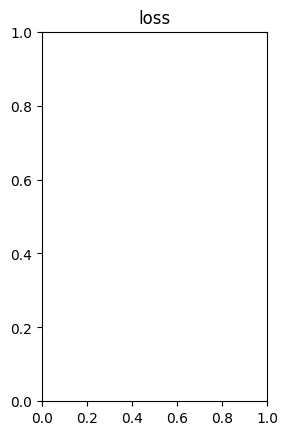

In [9]:
import matplotlib.pyplot as plt
x_epoch = []
fig = plt.figure()
ax0 = fig.add_subplot(121, title="loss")
x_epoch = []
y_loss = {}
y_loss['train'] = []
def draw_curve(current_epoch, losses):
    x_epoch.append(current_epoch)
    ax0.plot(x_epoch, y_loss['train'], 'bo-', label='train')
    if current_epoch == 0:
        ax0.legend()
    fig.savefig(os.path.join('./curve', 'train_pas.jpg'))

In [10]:
from engine import train_one_epoch, evaluate
import utils

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 21

dataset = VOCDataset('VOCtrain', get_transform(train=True))
dataset_test = VOCDataset('VOCtest', get_transform(train=False))

print(len(dataset))
print(len(dataset_test))

indices = torch.randperm(len(dataset)).tolist()
indices_test = torch.randperm(len(dataset_test)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-3500])
dataset_test = torch.utils.data.Subset(dataset_test, indices_test[:-4000])

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

model = get_model_instance(num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

num_epochs = 15
for epoch in range(num_epochs):
    _, loss = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    y_loss['train'].append(loss)
    draw_curve(epoch, loss)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device=device)
    torch.save(model, f'./chkpt_pas_cv2_{epoch}.pth')

5011
4952
Epoch: [0]  [  0/756]  eta: 1:13:14  lr: 0.000012  loss: 3.2598 (3.2598)  loss_classifier: 3.0863 (3.0863)  loss_box_reg: 0.1727 (0.1727)  loss_objectness: 0.0004 (0.0004)  loss_rpn_box_reg: 0.0004 (0.0004)  time: 5.8125  data: 2.4510  max mem: 3090
Epoch: [0]  [ 10/756]  eta: 0:24:53  lr: 0.000078  loss: 3.1307 (3.1967)  loss_classifier: 2.8941 (2.8696)  loss_box_reg: 0.2256 (0.3013)  loss_objectness: 0.0093 (0.0128)  loss_rpn_box_reg: 0.0080 (0.0130)  time: 2.0023  data: 1.2234  max mem: 3090
Epoch: [0]  [ 20/756]  eta: 0:23:58  lr: 0.000144  loss: 2.9846 (2.8497)  loss_classifier: 2.4559 (2.4125)  loss_box_reg: 0.3103 (0.4055)  loss_objectness: 0.0110 (0.0182)  loss_rpn_box_reg: 0.0113 (0.0135)  time: 1.7618  data: 1.2421  max mem: 3607
Epoch: [0]  [ 30/756]  eta: 0:23:32  lr: 0.000210  loss: 1.7771 (2.2709)  loss_classifier: 1.2379 (1.8447)  loss_box_reg: 0.4991 (0.3880)  loss_objectness: 0.0163 (0.0191)  loss_rpn_box_reg: 0.0180 (0.0191)  time: 1.9146  data: 1.3810  max 

In [12]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(